In [94]:
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

### Functions for extracting data

In [26]:
def extract_game_numbers_data(path_to_dir, time, dimension, game_numbers):
    data = {}
    for i in game_numbers:
        with open(f'{path_to_dir}/{time}_{dimension}_{i}.json') as json_file:
            data[i] = json.load(json_file)       
    return data

def extract_dimensions_data(path_to_dir, time, dimensions, game_numbers):
    data = {}
    for i in dimensions:
        data[i] = extract_game_numbers_data(path_to_dir, time, i, game_numbers)
    return data

def extract_times_data(path_to_dir, times, dimensions, game_numbers):
    data = {}
    for i in times:
        data[i] = extract_dimensions_data(path_to_dir, i, dimensions, game_numbers)
    return data

# Used to extract the full data tree for an entire directory of simulations. Indexed by the 
# time of the longer player, the dimension, then the game number. 
def read_games_from_json(path_to_dir, times, dimensions, game_numbers):
    data = extract_times_data(path_to_dir, times, dimensions, game_numbers)
    return data

### Functions for plotting experiment 1 results

In [33]:
def get_win_rate(data, time, dimension):
    long_wins = 0
    total_wins = 0
    
    if dimension == 'total':
        for d in data.keys():
            long, total = get_win_rate(data, time, d)
            long_wins += long
            total_wins += total
        return long_wins, total_wins
    
    else: 
        data = data[dimension]
        for game in data.values():
            if game['winner'] == time:
                long_wins += 1
                total_wins += 1
            elif game['winner'] != 0:
                total_wins += 1
        return long_wins, total_wins
    
def div_tuple(pair):
    if pair == (0, 0): return 0.5
    else: return pair[0] / pair[1]

# Plots win rate vs time given a full data tree of 2xSimulations. win rate is the number of times the longer player won
# over the number of times the shorter player won. Data is plotted for each dimension and aggregate. Requires 1st
# data representation
def plot_win_rate_vs_time(data):
    times = [time for time in data.keys()]
    time_buckets = [i for i in range(len(times))]
    dimensions = [d for d in data[times[0]].keys()]
    win_rates = []
    
    for dimension in dimensions:
        win_rates.append([div_tuple(get_win_rate(data[time], time, dimension)) for time in times])
    win_rates.append([div_tuple(get_win_rate(data[time], time, 'total')) for time in times])
    
    # Each row of win_rates corresponds to a fixed dimension. Each column is a fixed time. The last row
    # is an aggregate over all dimensions
    
    win_rates = np.array(win_rates)
    time_buckets = np.array(time_buckets)
    
    fig, ax = plt.subplots() 
    for i in range(len(dimensions)):
        ax.plot(time_buckets, win_rates[i], label=f'dim {dimensions[i]}')
    ax.plot(time_buckets, win_rates[-1], label=f'aggregate')
    ax.set_xlabel('Time Magnitude')
    ax.set_ylabel('Win Rate')
    ax.set_title('Win Rate vs Time Magnitutde')
    ax.legend()
                     
    

### Functions for plotting experiment 2 results

In [39]:
# Plots the number of simulations vs move_num. Called on the data for a single game. 
def plot_simulation_progression(game_data, title):
    time = game_data['p1']
    moves = game_data['moves']
    move_num = [i for i in range(1, len(moves) + 1)]
    sim_counts = []
    for i in range(len(moves)):
        sim_counts.append(moves[i]['simulations'])
    
    move_num = np.array(move_num)
    sim_counts = np.array(sim_counts)
    
    fig, ax = plt.subplots()
    ax.plot(move_num, sim_counts, label=f'{time} seconds')
    ax.set_xlabel('Move Number')
    ax.set_ylabel('Number of Simulations')
    ax.set_title(title)
    ax.legend()

In [63]:
# Plots number of simulations in the first move vs dimension given data that starts at a dimension index. 
def plot_simulation_vs_dimension(data, title):
    dimensions = [d for d in data.keys()]
    time = data[dimensions[0]][0]['p1']
    first_move_sim_counts = []
    for d in dimensions:
        game = data[d][0]
        first_move = game['moves'][0]
        first_move_sim_counts.append(first_move['simulations'])
    
    dimensions = np.array(dimensions)
    first_move_sim_counts = np.array(first_move_sim_counts)
    
    fig, ax = plt.subplots()
    ax.plot(dimensions, first_move_sim_counts, label=f'{time} seconds')
    ax.set_xlabel('Dimension')
    ax.set_ylabel('Number of Simulations')
    ax.set_title(title)
    ax.legend()
        

In [124]:
# Plots a scatter plot of best move_score vs move_num and plots points of different colors for different dimensions. 
# Takes in data at the dimension level of indexing
def plot_move_certainty_vs_move_num(data, title):
    dimensions = [d for d in data.keys()]
    move_num = []
    score = []
    color = cm.rainbow(np.linspace(0, 1, len(dimensions)))
    for d in dimensions:
        score_d = []
        move_num_d = []
        for game in data[d].values():
            moves = game['moves']
            for i in range(len(moves)):
                score_d.append(moves[i]['stats'][0]['pts']/moves[i]['stats'][0]['attempts'])
                move_num_d.append(i)
        move_num.append(move_num_d)
        score.append(score_d)
    
    move_num = np.array(move_num)
    score = np.array(score)
    
    fig, ax = plt.subplots()
    for i in range(len(dimensions)):
        ax.scatter(move_num[i], score[i], color=color[i], label=f'dim {dimensions[i]}', s=12)
    ax.set_xlabel('Move Num')
    ax.set_ylabel('Move Score')
    ax.set_title(title)
    ax.legend()
    return fig

In [123]:
# Plots a scatter plot of the distribution of move scores as the game progresses. Takes in the data for a specific game
def plot_move_score_distribution_progression(game_data, title):
    move_num = []
    move_score = []
    
    moves = game_data['moves']
    for i in range(len(moves)):
        move = moves[i]
        for stat in move['stats']:
            move_score.append(stat['pts']/stat['attempts'])
            move_num.append(i)
            
    move_num = np.array(move_num)
    move_score = np.array(move_score)
    
    fig, ax = plt.subplots()
    ax.scatter(move_num, move_score, color='blue', s=5)
    ax.set_xlabel('Move Num')
    ax.set_ylabel('Move Score')
    ax.set_title(title)
    return fig
    
        

### Experiment 1: Win Rate vs Time Magnitude Over Different Dimensions

In [42]:
# Joining data in 2xSimulations into a single Dictionary
times = [2 ** i for i in range(5)]
dimensions = [i for i in range(4, 9)]
game_numbers = [i for i in range(20)]
data1 = read_games_from_json('./2xSimulations', times, dimensions, game_numbers)

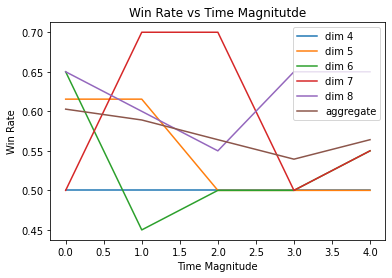

In [43]:
fig = plot_win_rate_vs_time(data1)

### Experiment 2: Number of Simulations Progression Through Game

In [44]:
times = [2 * i for i in range(1, 5)]
dimensions = [i for i in range(5, 13)]
game_numbers = [i for i in range(5)]
data2 = read_games_from_json('./EqualTimeSimulations', times, dimensions, game_numbers)

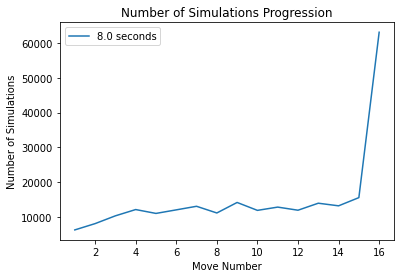

In [61]:
# Plotting simulation progression for game 8_8_2.json (8 seconds, dim 8, game 2). Changing the indexing plots for a 
# different game. The game shown shows the general trend for all
game_data = data2[8][8][2]
plot_simulation_progression(game_data, 'Number of Simulations Progression')

### Experiment 2: Number of Simulations as Dimensions Increase

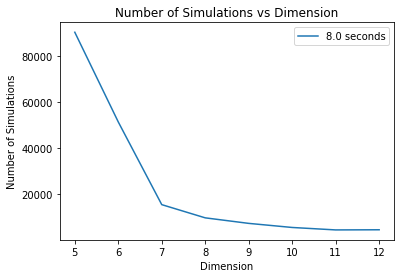

In [68]:
plot_simulation_vs_dimension(data2[8], 'Number of Simulations vs Dimension')

### Experiment 2: Move Certainty over Time

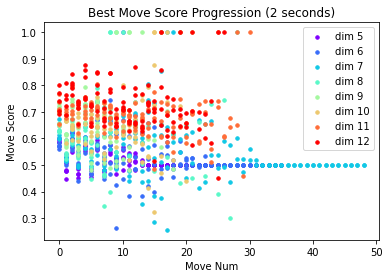

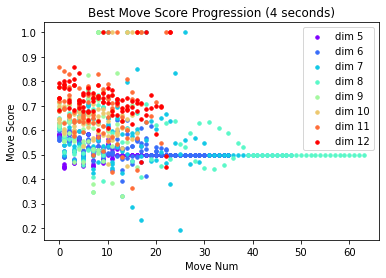

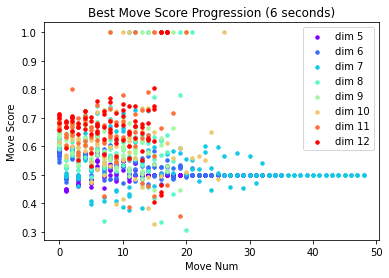

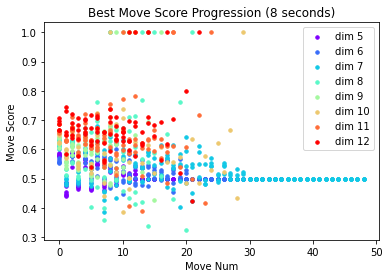

In [125]:
for i in data2.keys():
    fig = plot_move_certainty_vs_move_num(data2[i], f'Best Move Score Progression ({i} seconds)')
    fig.savefig(f'best_move_score_progression_{i}.png')

### Experiment 2: Distribution of Number of Attempts

<ipython-input-123-36aae875bb2d>:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


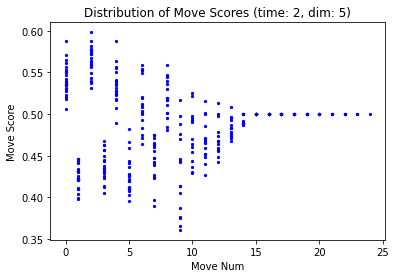

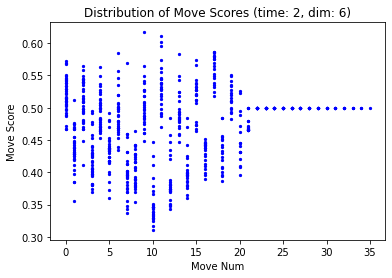

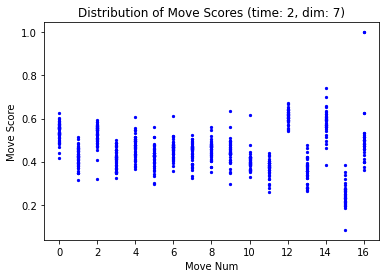

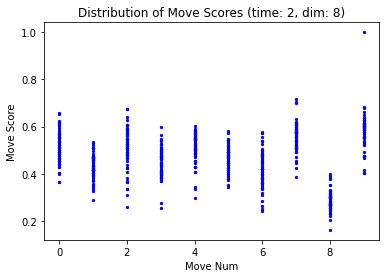

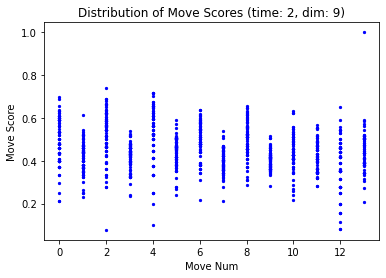

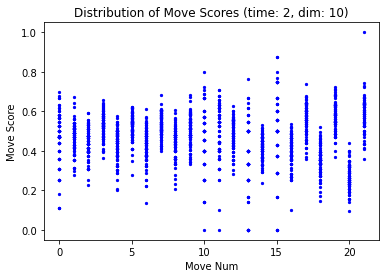

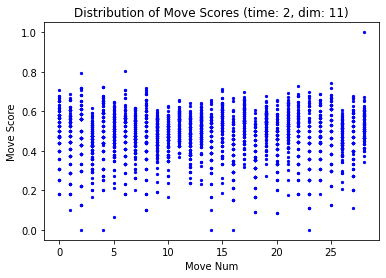

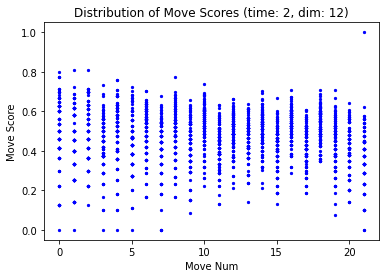

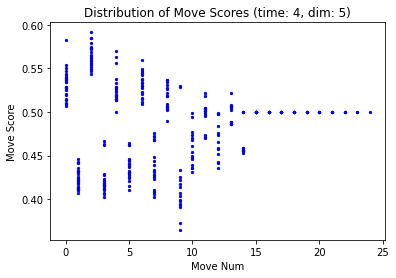

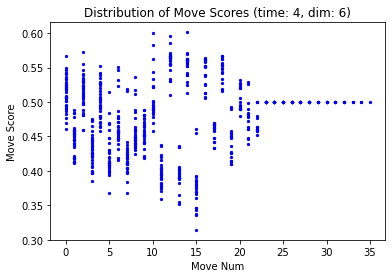

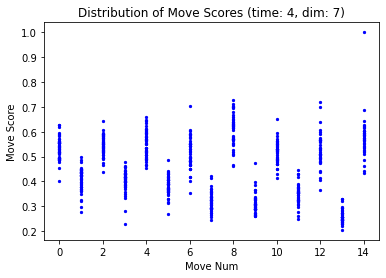

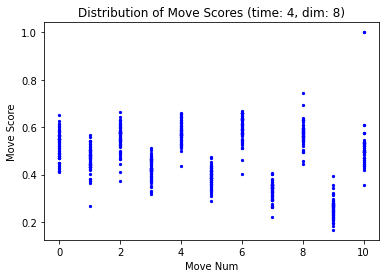

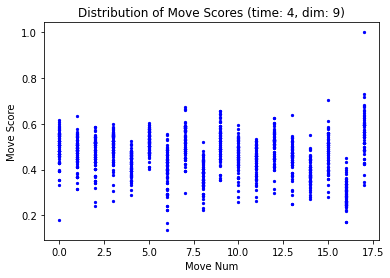

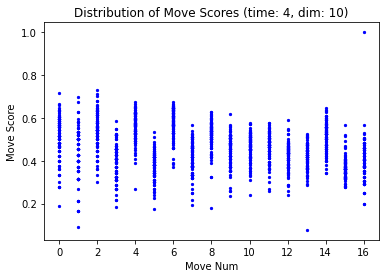

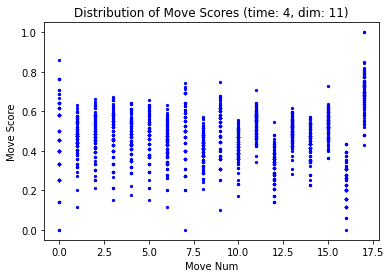

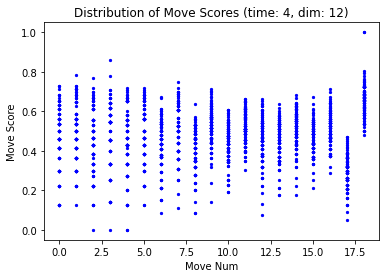

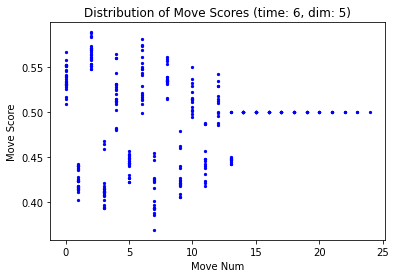

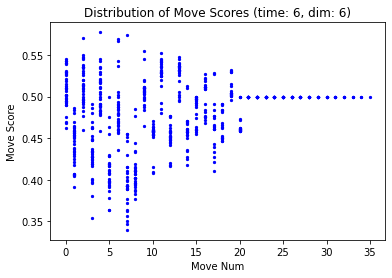

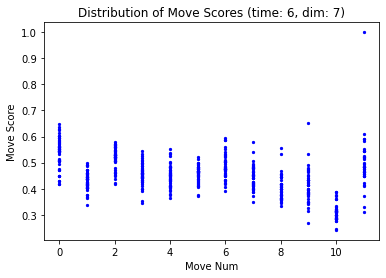

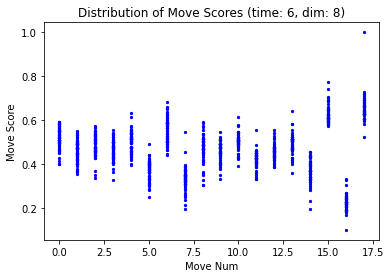

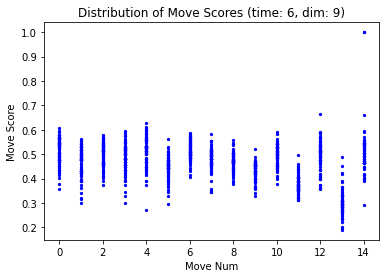

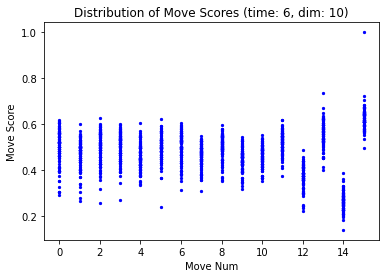

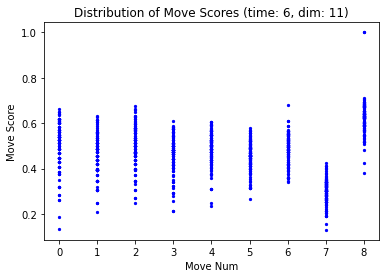

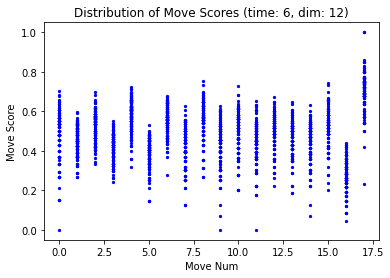

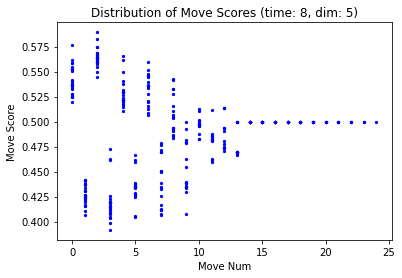

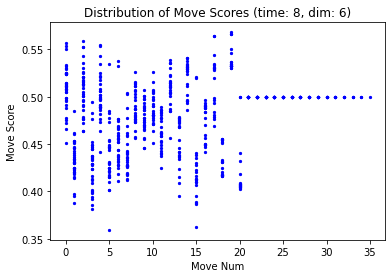

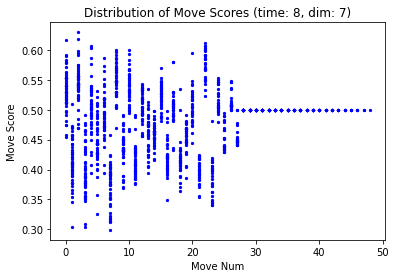

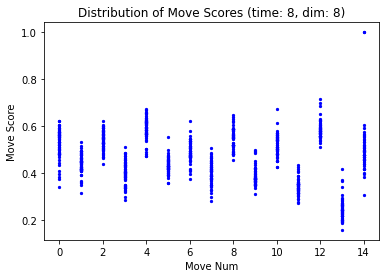

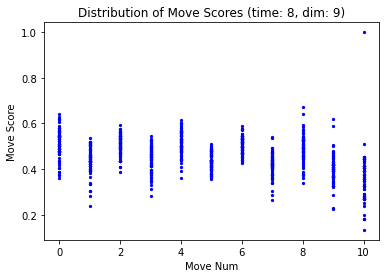

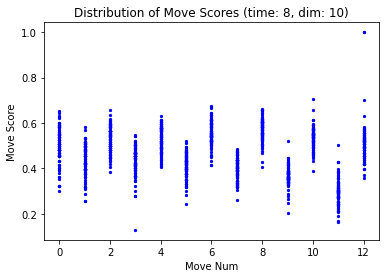

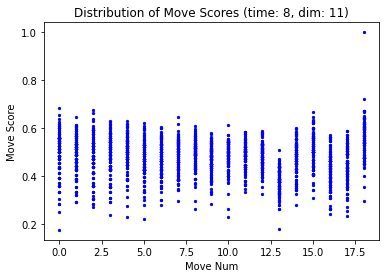

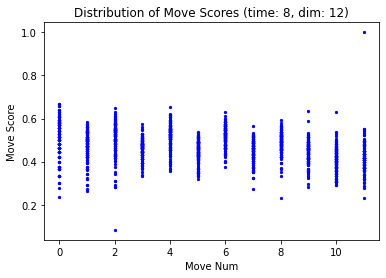

In [126]:
for t in times:
    for d in dimensions:
        g = 0 # Just use first game
        game_data = data2[t][d][g]
        fig = plot_move_score_distribution_progression(game_data, f'Distribution of Move Scores (time: {t}, dim: {d})')
        fig.savefig(f'move_score_distribution_{t}_{d}.png')